With the incredible amount of information being added to the internet every minute, it is humanly impossible to sift through all this data to find meaningful content for me to stay informed about everything that I want to. Additionally, with class and lectures put online, I personally have even more difficulty staying focused on the class material. I often notice myself switching the playback speed to 1.5 or 2 times for a while to have the pace of the slow parts feel good, but after a few moments I realize that I missed something important, need to rewind, and play what I already listened to at normal speed to understand all of the concepts portrayed in the video! Especially in review times before a test, I always have trouble sifting through hours worth of footage to find the example or content I was looking for.

## Background

In the Spring semester of 2019, I participated in a hackathon hosted by my school where I got this idea and worked on it a little bit. My idea was to give some importance value to each moment in the video, creating a sort of "importance curve". The "total importance" of the video could then be described as the area under the curve of this importance function. The toy example below can show spikes and valleys of importance, and the orange area resembles the most important moments of the video, and thus are the moments selected in the summarization.

It was a fun project to work on and I learned a lot from it! I thought while I'm practicing social distancing I might as well revisit this project and learn more about established video summarization techniques out there today.

## Available Free Videos

There is plenty of content online we can use for this. I'm going to be taking some of these [public test videos](https://gist.github.com/jsturgis/3b19447b304616f18657).

In [1]:
import os
import cv2
import json
import requests
import numpy as np
import pandas as pd
from skimage import transform
from IPython.display import Video
from matplotlib import pyplot as plt
from sklearn import metrics, cluster, decomposition

In [2]:
data_root = "../data/"
url_root = "https://commondatastorage.googleapis.com/gtv-videos-bucket/sample/"

In [3]:
with open(os.path.join(data_root, "videos.json"), 'r') as f:
    videos = json.load(f)
[v['title'] for v in videos]

['Big Buck Bunny',
 'Elephant Dream',
 'For Bigger Blazes',
 'For Bigger Escape',
 'For Bigger Fun',
 'For Bigger Joyrides',
 'For Bigger Meltdowns',
 'Sintel',
 'Subaru Outback On Street And Dirt',
 'Tears of Steel',
 'Volkswagen GTI Review',
 'We Are Going On Bullrun',
 'What care can you get for a grand?']

In [4]:
vid_url = url_root + videos[0]['sources'][0]
Video(vid_url, width=400)

## Preprocessing

One large challenge with automated summarization techniques is how computationally intensive video processing is. a 720p video has $720 \times 1280 \times 3 = 2764800$ values from 0 to 255 that define an R, G, or B value that together defines an image. That is only one frame, and at as few as 24 frames per second and as high as 60 frames per second, even a relatively short 10 minute clip can have almost 15 thousand frames. Keeping all this in mind, with current technology it is basically impossible to do computations on the entire matrix as-is. So before we do our work I make use of some pre-processing steps:

- Convert the color from RGB to grayscale
- Resize the video to 128p width and keep the aspect ratio the same
- Flatten each 2d frame to be one long 1d vector
- Perform PCA dimensionality reduction on the vector

All these strategies together reduce the dimensionality of the feature vector we are working with from several million attributes to less than 100, without a significant change in accuracy! While this process - not including loading the video into memory as that needs to be done regardless - takes quite some time, it makes all of our summarization techniques faster and possible to do without an enormous amount of RAM. Be warned that we can't take this to the extreme, as the smaller we push our dimensionality the less the data we make our summaries with can represent the original video. Make sure to keep as much information in the data as you can and still make meaningful yet quick summaries.

In [5]:
%%time
cap = cv2.VideoCapture(vid_url)
frameCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frameWidth = 128 # int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frameHeight = int(frameWidth * (cap.get(cv2.CAP_PROP_FRAME_HEIGHT) / cap.get(cv2.CAP_PROP_FRAME_WIDTH))) + 1
V = np.zeros((frameCount, frameHeight, frameWidth), np.dtype('uint8'))
f = 0
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret:
        frame_resized = cv2.resize(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY), (frameWidth, frameHeight), interpolation=cv2.INTER_CUBIC)
        V[f] = frame_resized
        f += 1
    else:
        break

cap.release()

Wall time: 41.2 s


In [ ]:
%%time
pca = decomposition.PCA(n_components=0.95)
V_flat = np.reshape(V, (-1, frameWidth * frameHeight))
V_reduced = pca.fit_transform(V_flat)
V_flat.shape[1], V_reduced.shape[1]

## Static Summarization

Static Summaries are frames from the original video chosen to summarize the overall visual.


### KMeans Clustering

In this example, we are making use of [VSUMM](https://www.ic.unicamp.br/~sandra/pdf/papers/avila_PRL11.pdf) 

In [66]:
%%time
clusters = 12
cols = 4
rows = int(clusters // cols)
kmeans = cluster.KMeans(n_clusters=clusters).fit_transform(V_reduced)
best_frames = np.sort(kmeans.argmin(axis=0))
best_frames

Wall time: 6.45 s


array([   16,    36,    40,    41,   976,  1981,  3478,  3515,  6999,
        9707, 12196, 13596], dtype=int64)

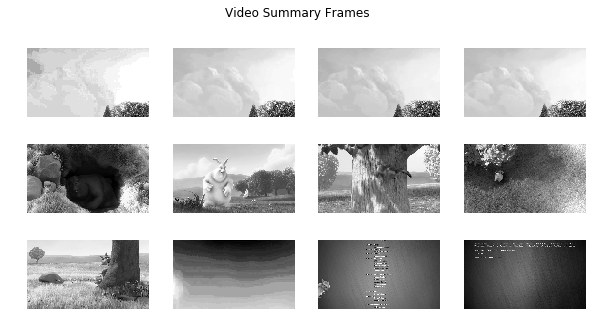

In [67]:
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 5))
for idx, f in enumerate(best_frames):
    i = idx // cols
    j = idx % cols
    frame = V[f]
    axes[i, j].imshow(frame, cmap='gray')
    axes[i, j].axis('off')
fig.suptitle("Video Summary Frames")
plt.show()

### Representative Frames

In [68]:
D = metrics.pairwise_distances(V_reduced, metric="cosine").mean(axis=1)
frames = []
for i in range(clusters):
    if not len(frames):
        curr = D
    else:
        redundancy = metrics.pairwise_distances(V_reduced, frames, metric="cosine").max(axis=1)
        curr = (1 - redundancy) * D
    best_frame = curr.argmax()
    print(best_frame)
    frames.append(V_reduced[best_frame])

10340
10340
10340
10340
10340
10340
10340
10340
10340
10340
10340
10340
